# Валидация на отложеннной скважине

In [1]:
import os
import sys
import glob

sys.path.insert(0, os.path.join("..", "..", ".."))

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import PIL
from PIL import Image

from well_logs import CoreBatch
from well_logs.batchflow import Dataset, Pipeline, B, V, FilesIndex
from well_logs.batchflow.models.torch import ResNet18
from utils import plot_pair, make_data, get_bounds, assemble, plot_images_predictions, plot_crops_predictions

Загрузим разметку для отложенной скважины

In [2]:
PATH = '/notebooks/data/test_dataset/*'

index = FilesIndex(path=os.path.join(PATH, 'samples_dl/*.png'))

## Предобработка

In [3]:
df = pd.concat([pd.read_feather(filename) for filename in glob.glob(PATH+'/samples.feather')])
df['QC'] = 1 - df['QC']
df = df.set_index('SAMPLE')

In [4]:
index = index.create_subset(np.intersect1d(df.index.values, index.indices))
ds = Dataset(index, CoreBatch)

In [5]:
SHAPE = (2, 400, 150)

In [6]:
shape_ppl = (ds.p
     .load()
     .check_shapes(dst='check')
     .init_variable('quality', init_on_each_run=list)
     .update_variable('quality', B('check'), mode='e')
     .init_variable('shape1', init_on_each_run=list)
     .run(batch_size=10, n_epochs=1, shuffle=False, drop_last=False, lazy=True, bar=False)
    )

shape_ppl.run()

In [7]:
short_ppl = (ds.p
     .load()
     .find_short_cores(SHAPE[1:], dst='short')
     .init_variable('short', init_on_each_run=list)
     .update_variable('short', B('short'), mode='e')
     .run(batch_size=10, n_epochs=1, shuffle=False, drop_last=False, lazy=True, bar=False)
    )

short_ppl.run()

filtered_index = ds.index.create_subset(
    ds.indices[np.logical_not(short_ppl.get_variable('short') or shape_ppl.get_variable('quality'))]
)

In [8]:
filtered_df = Dataset(filtered_index, CoreBatch)

In [9]:
bounds = get_bounds(PATH)

In [10]:
load_ppl = (Pipeline().load(grayscale=True, df=df).normalize(bounds=bounds))

# Валидация

In [11]:
test_template = (Pipeline()
    .to_array(src='uv', dst='uv', channels='first')
    .to_array(src='dl', dst='dl', channels='first')
    .crop(SHAPE[1:], 200, dst=('dl_crops', 'uv_crops', 'labels_crops'))
    .init_model('dynamic', ResNet18, 'model', config={
                    'device': 'gpu:2', 'load/path': 'resnet16.torch'
                })
    .init_variable('loss', init_on_each_run=list)
    .call(make_data, save_to=(B('crops_conc'), B('labels_crops_conc')))
    .init_variable('proba', init_on_each_run=None)
    .init_variable('metrics', init_on_each_run=None)
    .predict_model('model', B('crops_conc'), targets=B('labels_crops_conc'), fetches='proba',
                 save_to=B('proba', mode='w'))
    .call(assemble, save_to=B('proba', mode='w'))
    .gather_metrics('class', targets=B('labels'), predictions=B('proba'),
                            fmt='proba', axis=-1, save_to=V('metrics', mode='u'), threshold=0.5)
    .init_variable('stat', init_on_each_run=list)
    .update_variable('stat', (B('dl'), B('uv'), B('proba'), B('labels')), mode='a')
    .run(
        batch_size=8,
        n_epochs=1,
        shuffle=False,
        drop_last=False,
        lazy=True,
        bar=True
    )
)

In [12]:
test_ppl = (load_ppl + test_template) << filtered_df

In [13]:
test_ppl.reset_iter()
test_ppl.run()

 98%|█████████▊| 55/56 [00:30<00:00,  2.08it/s]


In [14]:
metrics = test_ppl.get_variable('metrics')
print(metrics._confusion_matrix)

for m in ['specificity', 'sensitivity', 'accuracy']:
    print(m, ':', metrics.evaluate(m))

[[[390  12]
  [ 40   3]]]
specificity : 0.9069767441860465
sensitivity : 0.2
accuracy : 0.8831460674157303


Как мы видим, модель ошибается и часто относит небракованные пары к бракованным. Рассмотрим примеры изображений, на которых происходят ошибки.

# False negative

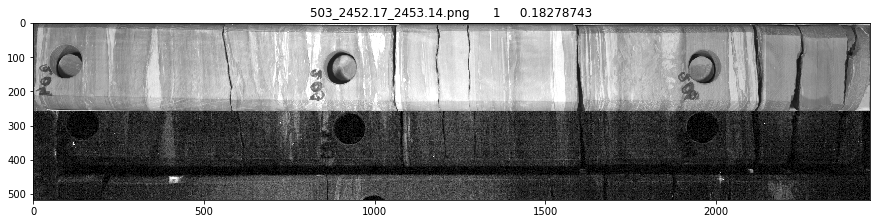

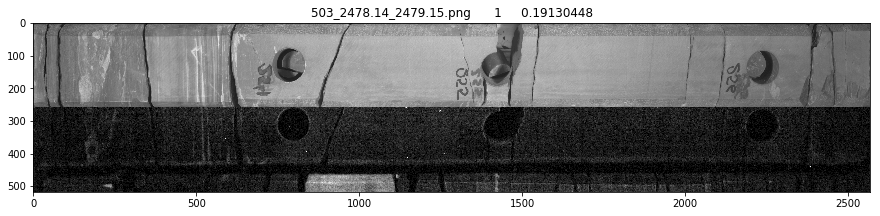

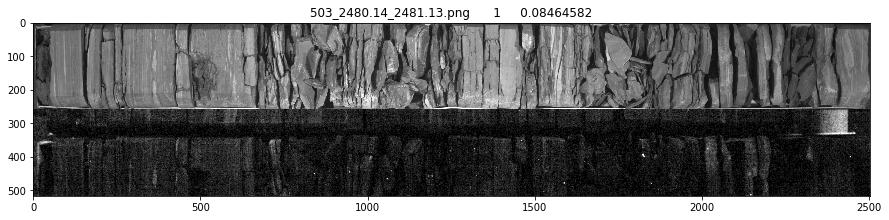

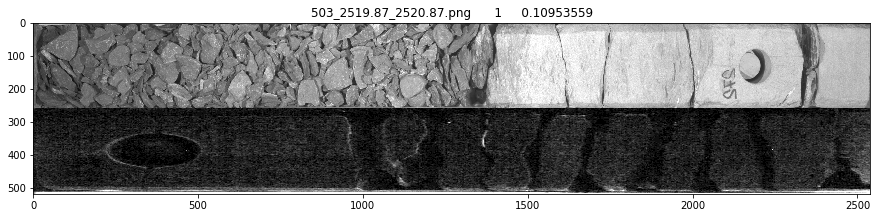

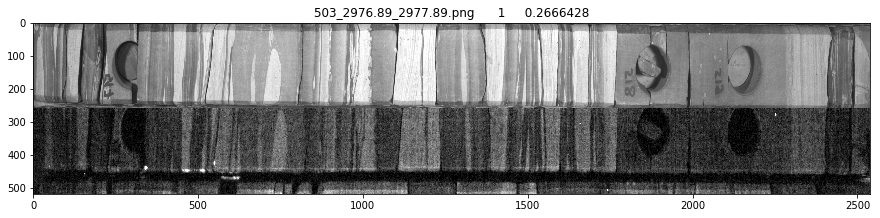

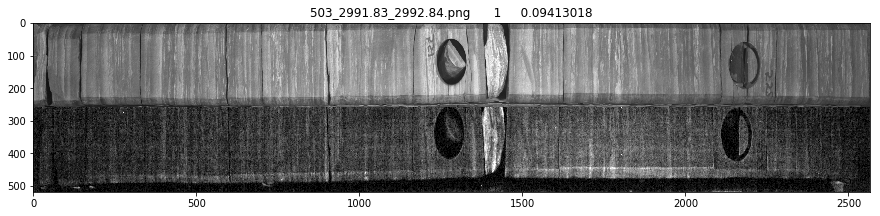

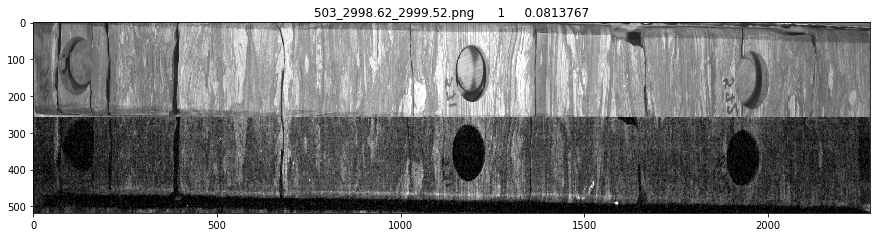

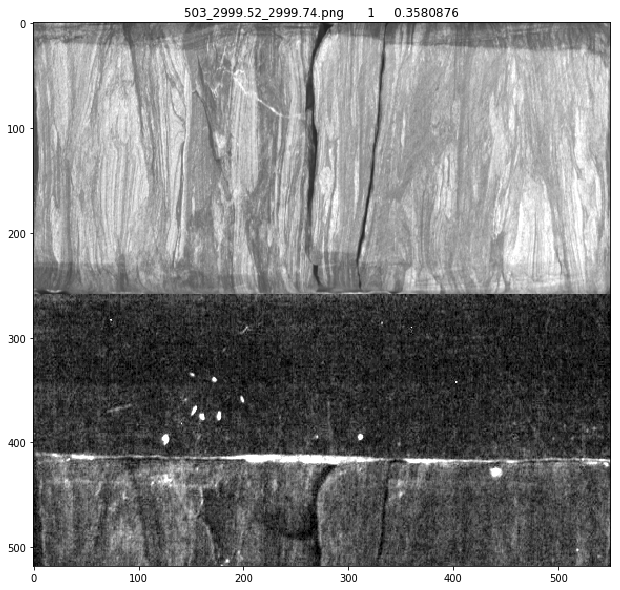

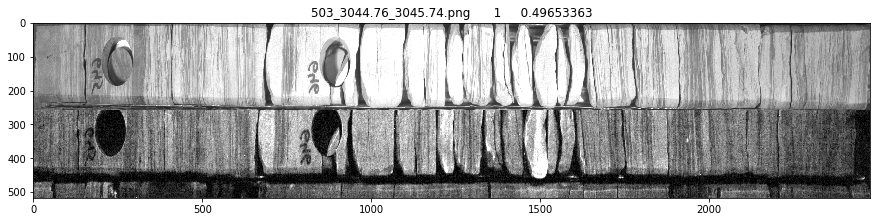

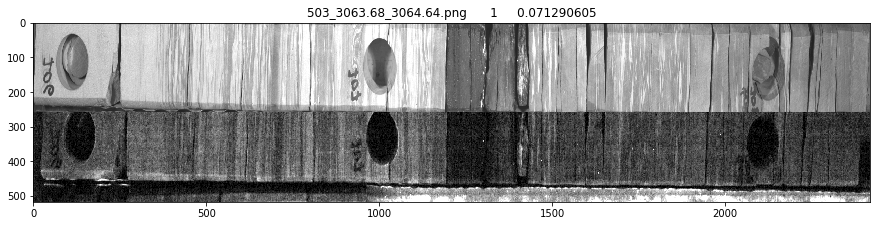

In [15]:
plot_images_predictions(test_ppl, 'fn')

# False positive

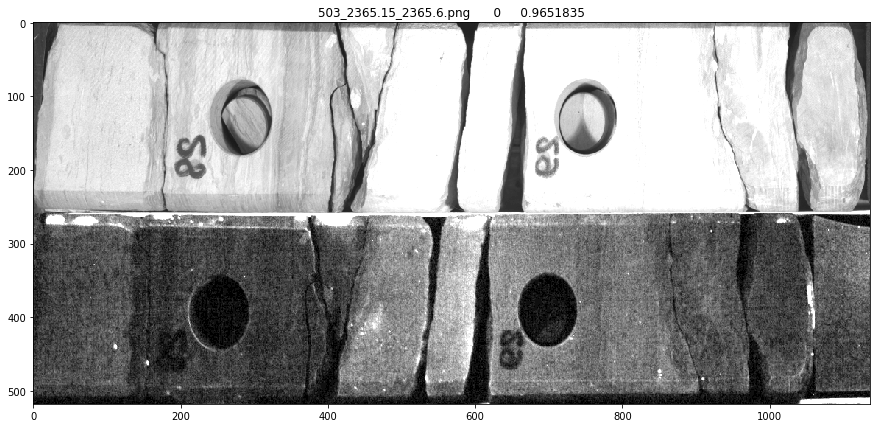

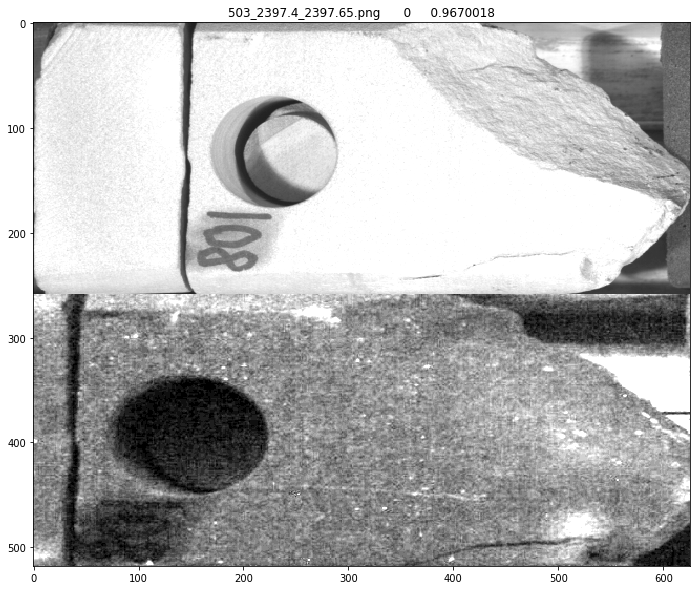

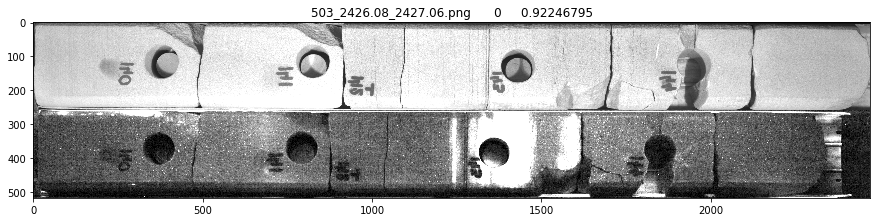

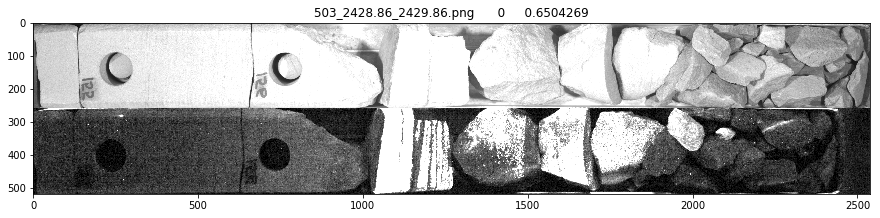

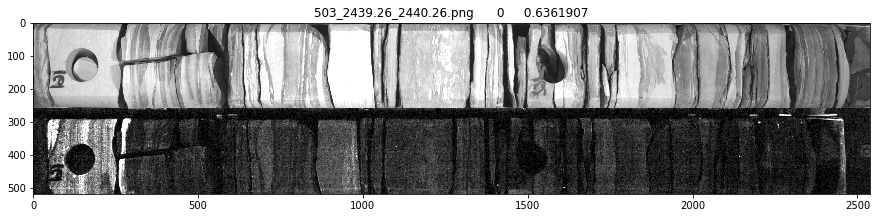

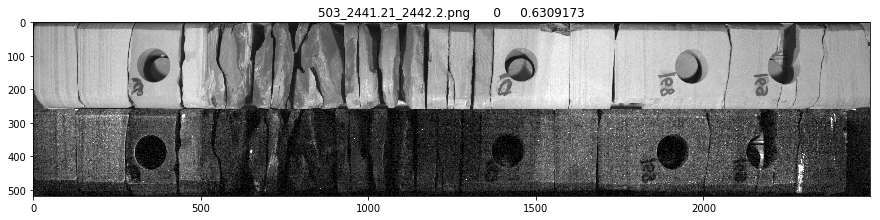

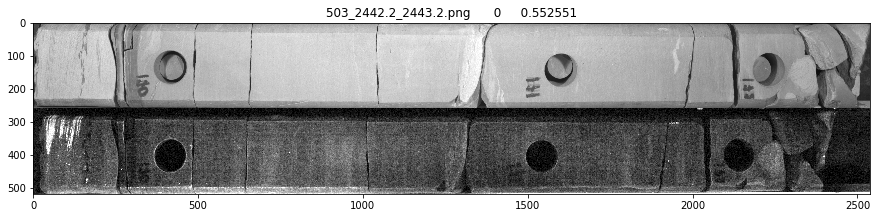

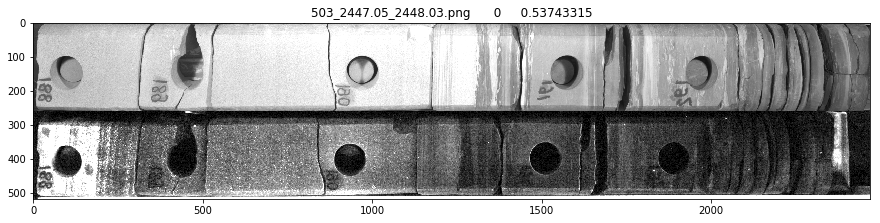

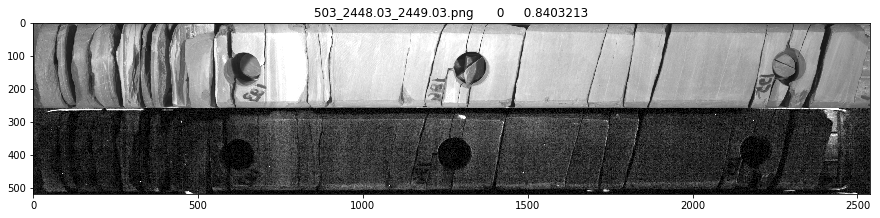

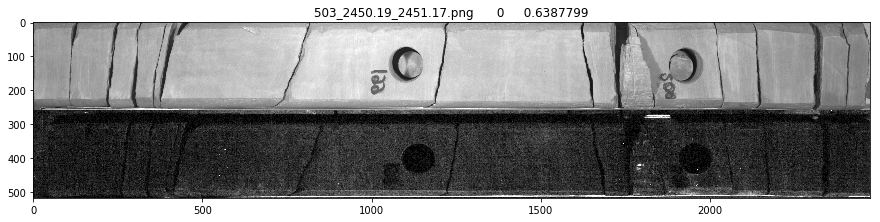

In [16]:
plot_images_predictions(test_ppl, 'fp')

# True positive

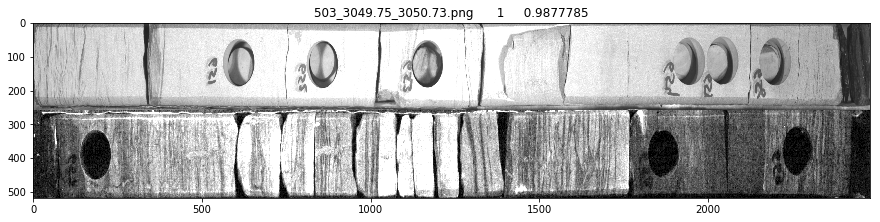

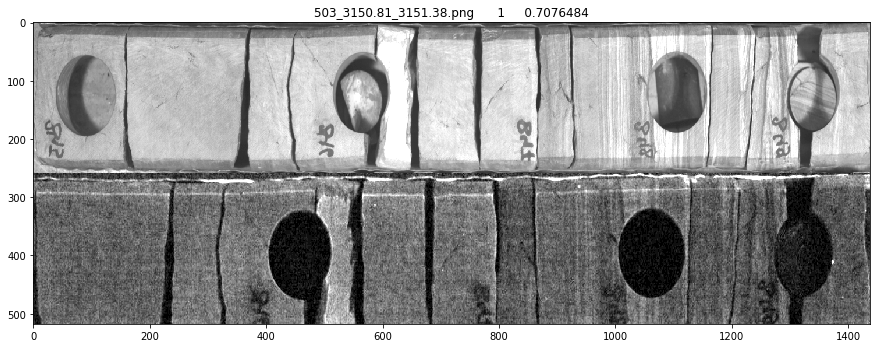

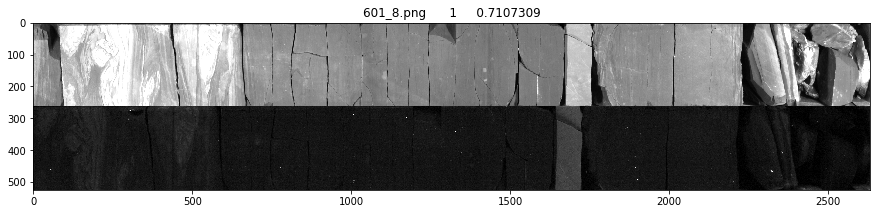

In [17]:
plot_images_predictions(test_ppl, 'tp')

# True negative

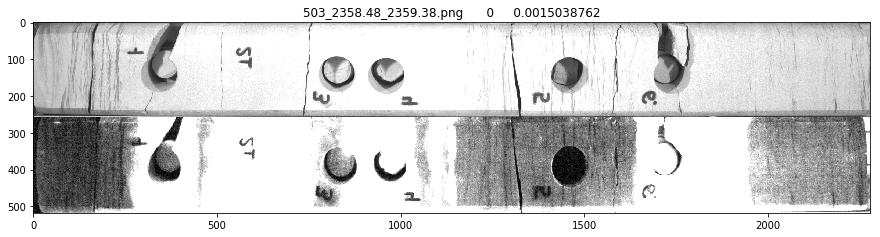

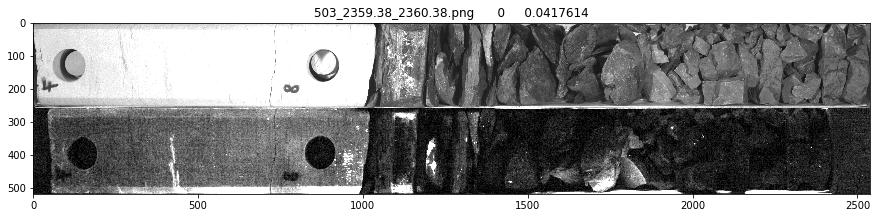

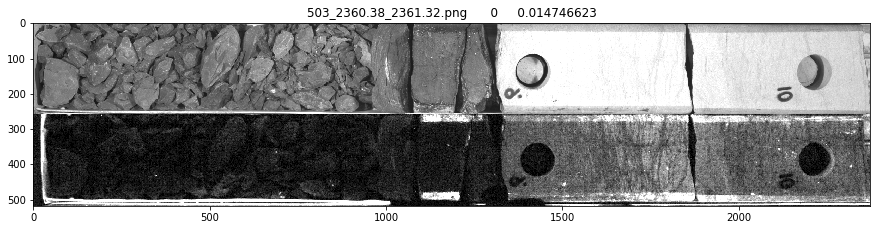

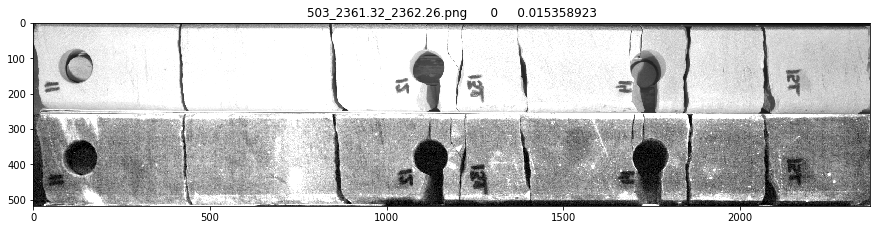

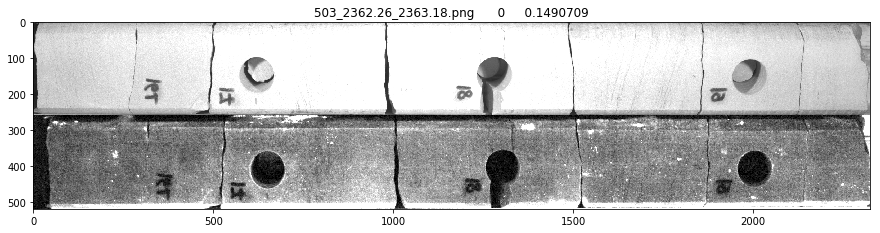

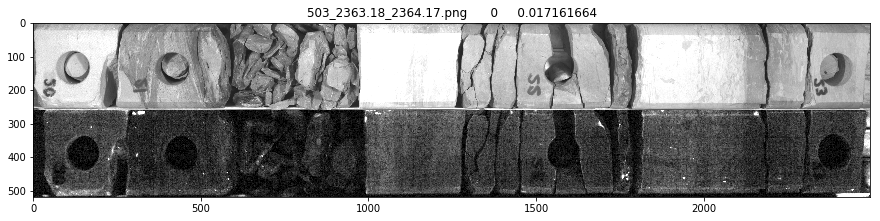

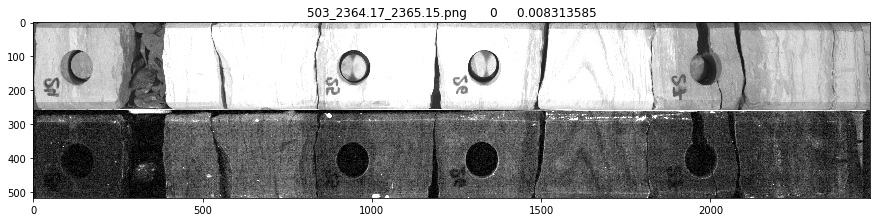

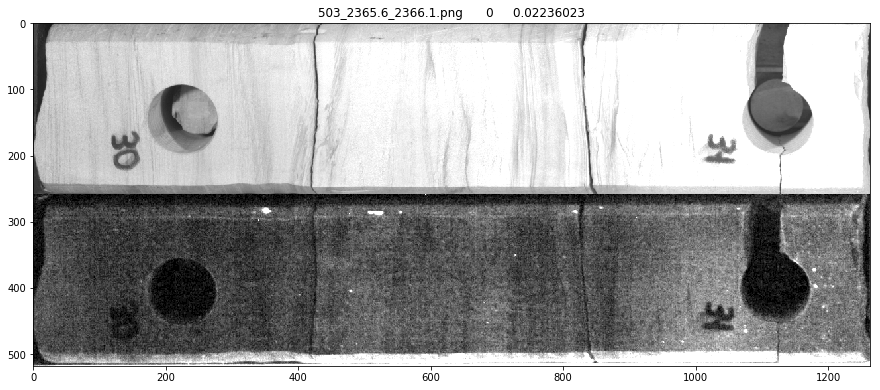

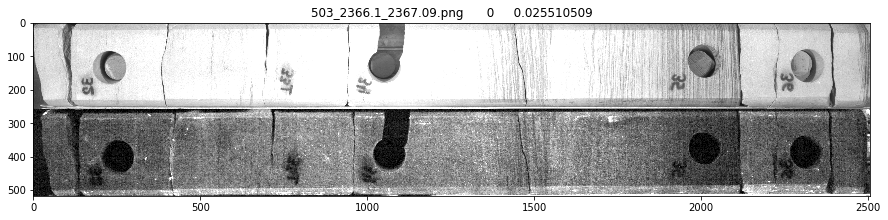

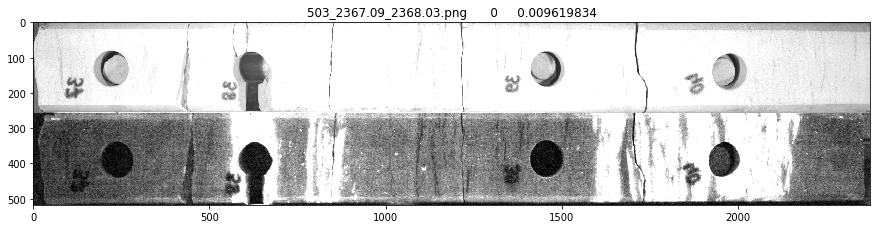

In [18]:
plot_predictions(test_ppl, 'tn')

# Вывод

Модель срабатывает в случаях, когда фотографии сдвинуты по вертикали относительно друг друга, а такие пары в разметке не относятся к бракованным.